In [3]:
SAMPLING = '2000_win10-0'
DATASETS = ['LGI_PPGI', 'MR_NIRP', 'UBFC_PHYS']

In [4]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
import pandas as pd
import seaborn as sns
import os
import constants
import matplotlib.pyplot as plt
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors
from pyVHR.extraction.utils import CustomLandmarks
from pyVHR.plot.visualize import *
from analyze import *

vhr.plot.VisualizeParams.renderer = 'vscode' 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

all_landmarks = list(CustomLandmarks().get_all_landmarks().keys())

PALETTE = 'Spectral' # "Spectral"
ROIS = ['forehead', 'nose', 'cheeks','mustache', 'temple','jaw']
SETTINGS = get_dataset_settings(DATASETS)
top_landmarks = ['malar', 'glabella', 'lower_lateral_forehead', 'lower_medial_forehead', 'upper_nasal_dorsum', 'soft_triangle', 'lower_cheek', 'marionette_fold', 'chin']


Video settings in LGI_PPGI:  dict_keys(['GYM', 'STILL', 'ROTATION', 'TALK', 'MALE', 'FEMALE', 'BEARD', 'GLASSES'])
Video settings in MR_NIRP:  dict_keys(['MOTION', 'STILL', 'MALE', 'FEMALE', 'BEARD', 'DARK'])
Video settings in UBFC_PHYS:  dict_keys(['STILL', 'MALE', 'FEMALE', 'GLASSES', 'ROTATION', 'BEARD', 'DARK', 'BANG'])


In [5]:
# Sanity check 

# df[df['landmarks'].isin([('glabella',)])].query("videoFilename == 'Subject1_motion_940'")
# df.groupby('landmarks').videoFilename.unique().apply(lambda x: len(x)).sort_values(ascending=False)
metrics = ['MAE',  'timePCC', 'timeDTW',  'MAE_z', 'timePCC_z', 'timeDTW_z', 'OS']
# df[['landmarks', 'videoFilename'] + metrics].query("landmarks == 'glabella'")
# df.query('dataset == "mr_nirp"').boxplot(column='OS', by='videoFilename', figsize=(16,3), rot=90)


# Enhanced by Face

In [44]:
def __get_df(df, metric='MAE'):
    df = format_data(df).drop(columns=['config', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', ])
    df = format_data_symmetric_landmark(df, symmetric=True) 
    df['ldmk_MAE'] = df.groupby(['landmarks'])['MAE'].transform('mean')
    df['video_MAE'] = df.groupby(['videoFilename'])['MAE'].transform('mean') 
    return df

def __get_df_brightness(dataset_name, metric):
    df = __get_df(pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5').query("method == 'cupy_CHROM'"))
    df['brightness'] = 0
    levels = [60,100, 140]
    for level in levels:
        tmp = __get_df(pd.read_hdf(f'../results/brightness_{level}/{dataset_name}/{dataset_name}_18.h5'))
        tmp['brightness'] = level
        df = pd.concat([df, tmp], ignore_index=True) 
    return df

def compare_landmarks_brightness(datasets, metric='MAE'):
    """
        Plot boxplot of landmarks by brightness levels
    """
    df = pd.DataFrame()
    for dataset_name in datasets:   
        df = pd.concat([df, __get_df_brightness(dataset_name, metric)], ignore_index=True)
    # df = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') | (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)
    print("Brightness levels: " , df.brightness.unique())

    groupby_col = ['landmarks', 'brightness']
    grouped = df[['landmarks', 'brightness',metric]].groupby(groupby_col).median()
    grouped_original = grouped.reset_index(level=1).query('brightness == 0').sort_values(by=metric).copy() # sort by median
    df_good = df[df['landmarks'].isin(top_landmarks)].copy()
    df_bad = df[~df['landmarks'].isin(top_landmarks)].copy()

    def boxplot_landmarks(df, grouped, metric, ax):
        # palette = sns.color_palette("husl", len(grouped.index))
        box = sns.boxplot(x='landmarks', y=metric, data=df, order=grouped.index, hue='brightness', ax=ax, showfliers=False, palette=sns.color_palette('rocket_r', len(df.brightness.unique())))
        # box = sns.boxplot(x='landmarks', y=metric, data=df, order=grouped.index, hue='brightness', ax=ax, showfliers=False)
        labels = [item.get_text().replace('_', ' ')  for item in box.get_xticklabels()]
        box.set_xticks(range(len(labels)))
        box.set_xticklabels(labels,rotation=90, fontsize=10)
        if metric == 'MAE': metric = r'$\Delta$' + 'BPM'
        if metric == 'timeDTW': metric = 'DTW'
        if metric == 'score': metric = 'OS'
        box.set_xlabel('Landmark')
        box.set_ylabel(metric)
        return box

    fig, ax = plt.subplots(2,1, figsize=(16,8))
    box1 = boxplot_landmarks(df_good, grouped_original.loc[grouped_original.index.get_level_values('landmarks').isin(top_landmarks)], metric, ax[0])
    box2 = boxplot_landmarks(df_bad, grouped_original.loc[~grouped_original.index.get_level_values('landmarks').isin(top_landmarks)], metric, ax[1])
    plt.tight_layout()

    return df, grouped, fig

Brightness levels:  [  0  60 100 140]


landmarks brightness        MAE           
                                            mean     median
0                 glabella          0   9.139052   3.662923
1   lower_lateral_forehead          0  10.194343   5.683512
2    lower_medial_forehead          0   9.672906   7.378906
3                    malar          0  11.895711   8.002035
4              lower_cheek          0  12.978895  10.378092
5       upper_nasal_dorsum          0  13.407254  10.904948
6                     chin          0  15.063721  11.072103
9          marionette_fold          0  14.091098  12.403564
10    lower_nasal_sidewall         60  16.980898  13.326660
11      mid_nasal_sidewall         60  16.092729  13.340739
24         nasolabial_fold         60  17.326290  15.314860
25                     ala         60  18.226341  15.539469
29                temporal        100  18.407160  16.126302
35               upper_lip        100  18.926299  16.768148
36                philtrum         60  20.122366  16.812826
41           soft_triangle         60  21.790897  17.780762
44      lower_nasal_dorsum         60  19.524902  18.194661
52               nasal_tip         60  21.354625  20.086914

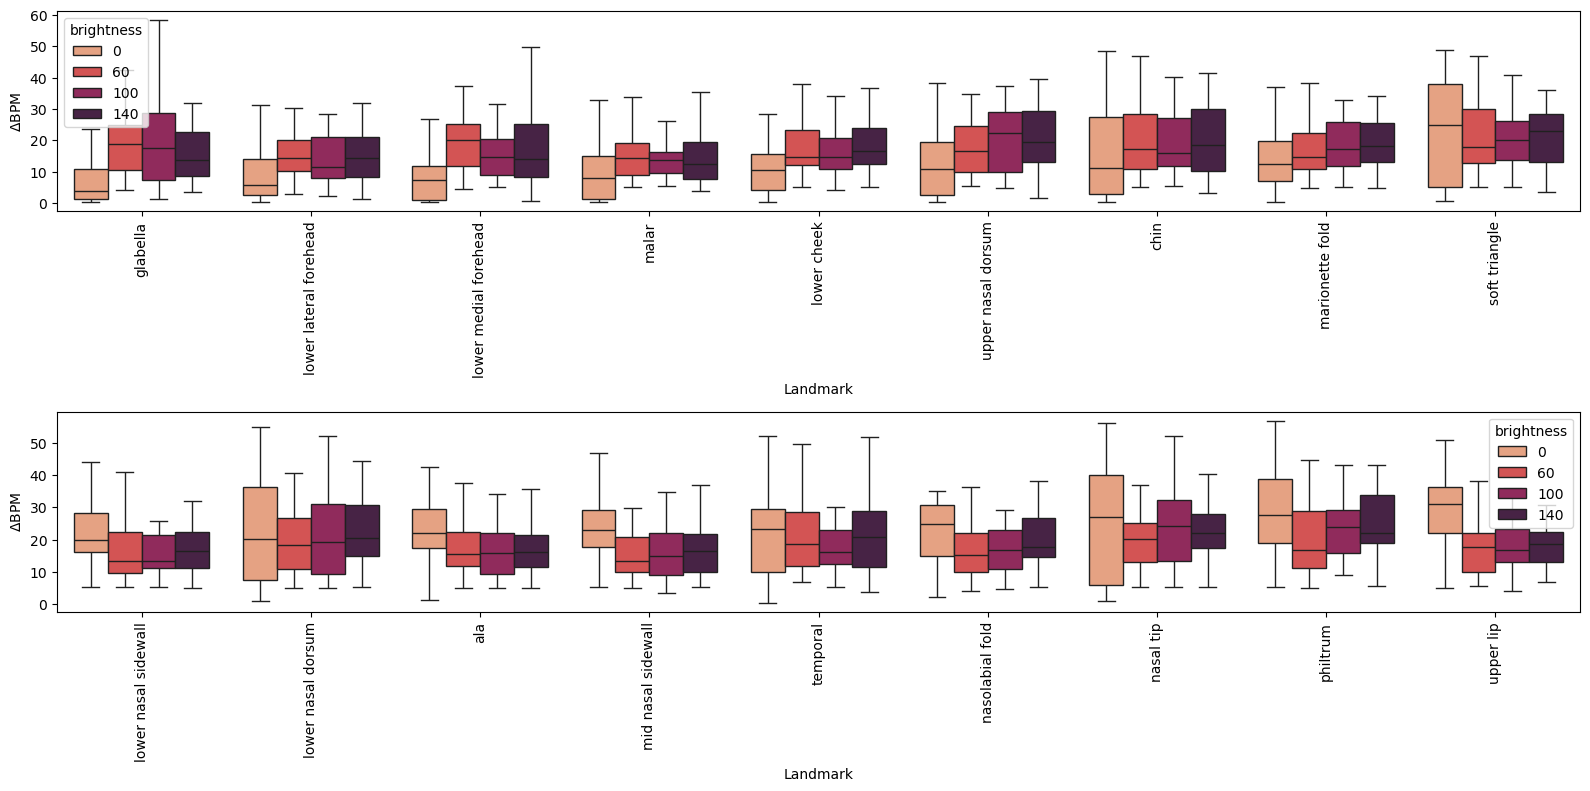

In [45]:
df, grouped, fig = compare_landmarks_brightness(['LGI_PPGI'])
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'median')).reset_index().groupby('landmarks').head(1) # mean
# df, grouped, fig = compare_landmarks_brightness(['LGI_PPGI'], 'score')
# df[['landmarks', 'brightness','score']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('score', 'median')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

Brightness levels:  [  0  60 100 140]


landmarks brightness        MAE           
                                            mean     median
0                 glabella          0   8.663040   4.635120
1            soft_triangle          0   8.701509   4.657443
2   lower_lateral_forehead          0   9.384147   5.300426
3                    malar          0   8.749734   5.536885
4       upper_nasal_dorsum          0   9.503555   5.811908
5                      ala          0   9.615956   6.403578
6                nasal_tip          0  11.189786   6.716156
7    lower_medial_forehead          0   9.538566   6.816411
8                     chin          0   9.889695   7.698089
9          marionette_fold          0   9.553410   7.832973
10      lower_nasal_dorsum          0  11.504354   7.875495
11         nasolabial_fold          0   9.075996   8.039554
12             lower_cheek          0  10.214452   8.307332
13    lower_nasal_sidewall          0  11.054601   9.097535
14                philtrum          0  12.485898   9.765799
20      mid_nasal_sidewall          0  14.132474  13.023673
23               upper_lip          0  16.252221  13.887821
38                temporal          0  17.959624  17.189968

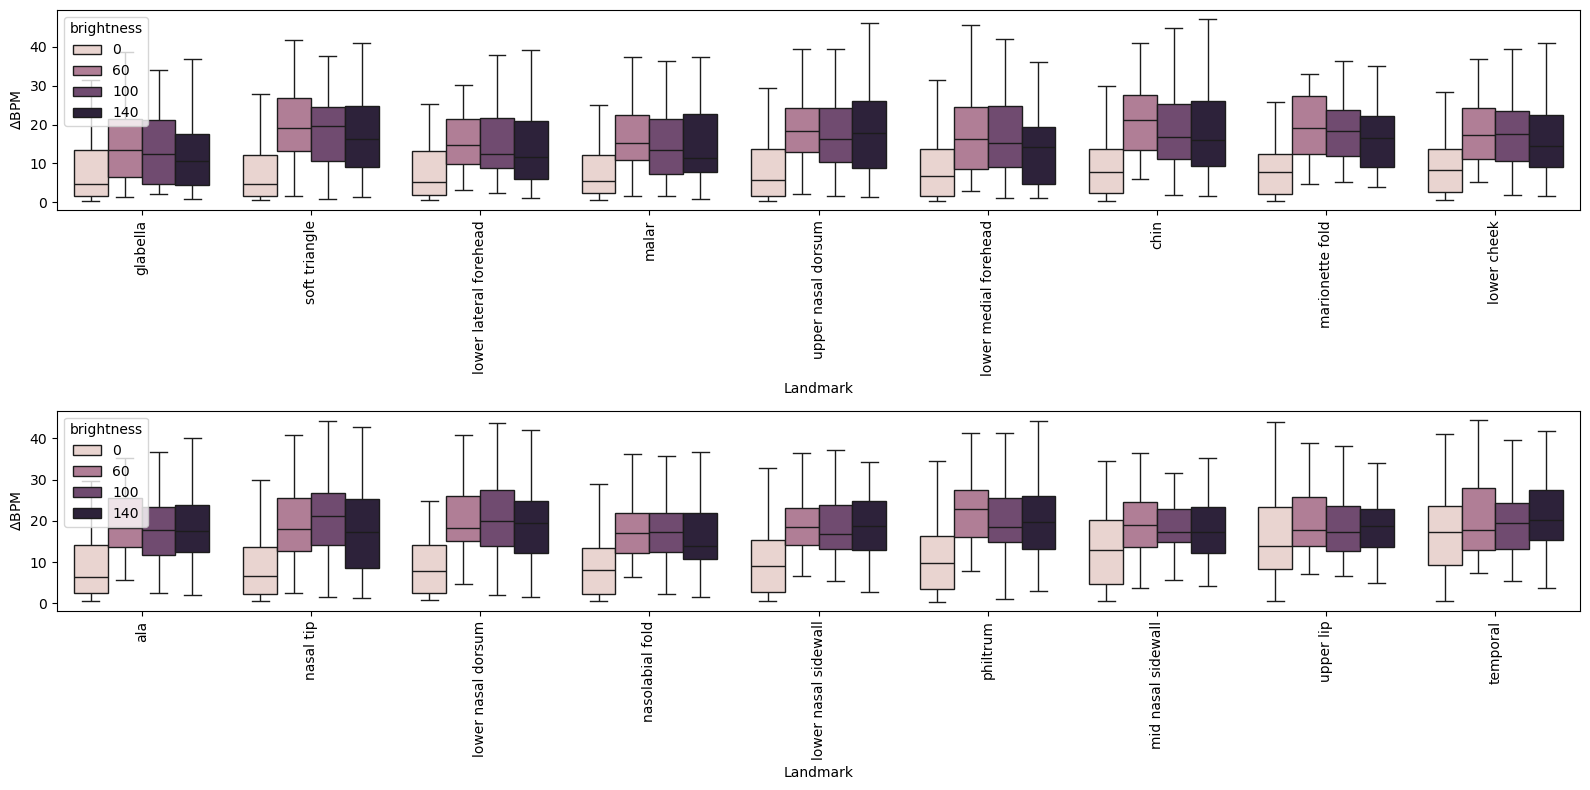

In [12]:
df, grouped, fig = compare_landmarks_brightness(['UBFC_PHYS'])
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'median')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

Brightness levels:  [  0  60 100 140]


landmarks brightness        MAE           
                                            mean     median
0   lower_lateral_forehead          0   0.820597   0.740234
1                    malar          0   0.780396   0.757975
2                nasal_tip          0   1.769450   0.803711
3       lower_nasal_dorsum          0   1.022054   0.814779
4    lower_medial_forehead          0   1.030111   0.863607
5                 glabella          0   0.965088   0.926107
6              lower_cheek          0   3.809774   0.975098
7       upper_nasal_dorsum          0   1.068278   1.061198
8     lower_nasal_sidewall          0   3.422933   1.125163
9            soft_triangle          0   1.347005   1.220052
10         nasolabial_fold          0   3.630778   1.234538
11                     ala          0   5.819621   1.299642
12                    chin          0   4.800618   1.558594
13      mid_nasal_sidewall          0   7.615723   2.012370
19         marionette_fold          0  12.337687   6.771159
31               upper_lip        100  13.585815  11.894694
43                philtrum          0  25.749593  13.764974
54                temporal        100  16.886759  15.776204

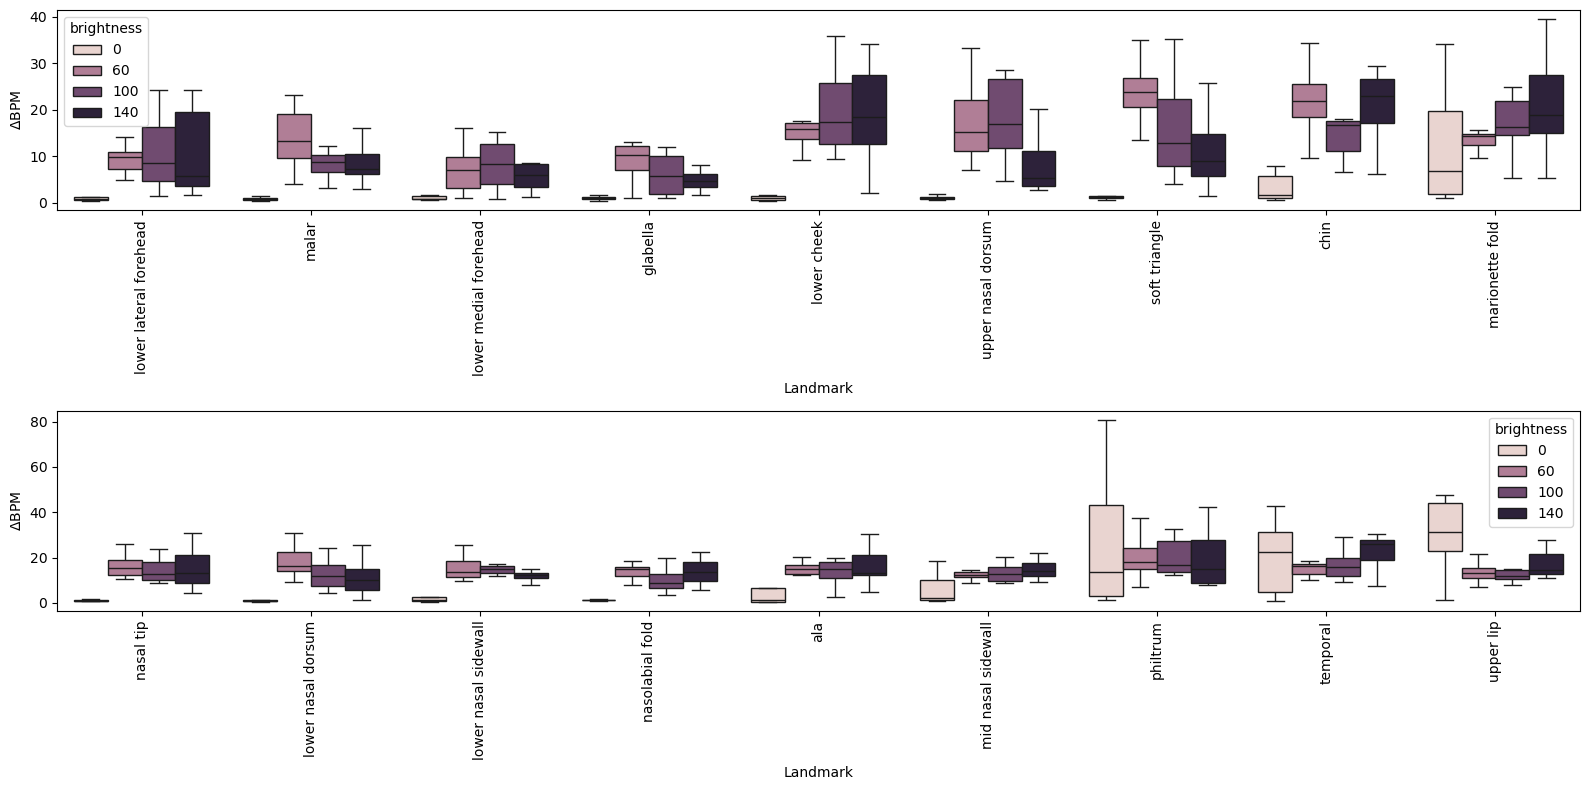

In [14]:
df, grouped, fig = compare_landmarks_brightness(['MR_NIRP'])
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'median')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

Brightness levels:  [  0  60 100 140]


landmarks brightness        MAE           
                                            mean     median
0                 glabella          0   8.093048   3.662858
1                    malar          0   8.883242   4.712600
2   lower_lateral_forehead          0   8.826605   4.868505
3    lower_medial_forehead          0   8.801708   5.349121
4       upper_nasal_dorsum          0   9.801356   5.660807
5            soft_triangle          0  11.599328   5.660807
6                nasal_tip          0  14.069459   6.987241
7                     chin          0  10.838150   7.543470
8              lower_cheek          0  10.386148   8.378463
9       lower_nasal_dorsum          0  13.593754   8.844606
10         marionette_fold          0  11.044077   9.327718
11         nasolabial_fold          0  11.991715   9.412581
12                     ala          0  12.677887   9.719445
18    lower_nasal_sidewall          0  13.839765  12.336281
23                philtrum          0  18.199888  14.437345
27      mid_nasal_sidewall          0  16.136226  15.454541
33               upper_lip        100  18.397590  16.271891
50                temporal         60  20.496003  17.281413

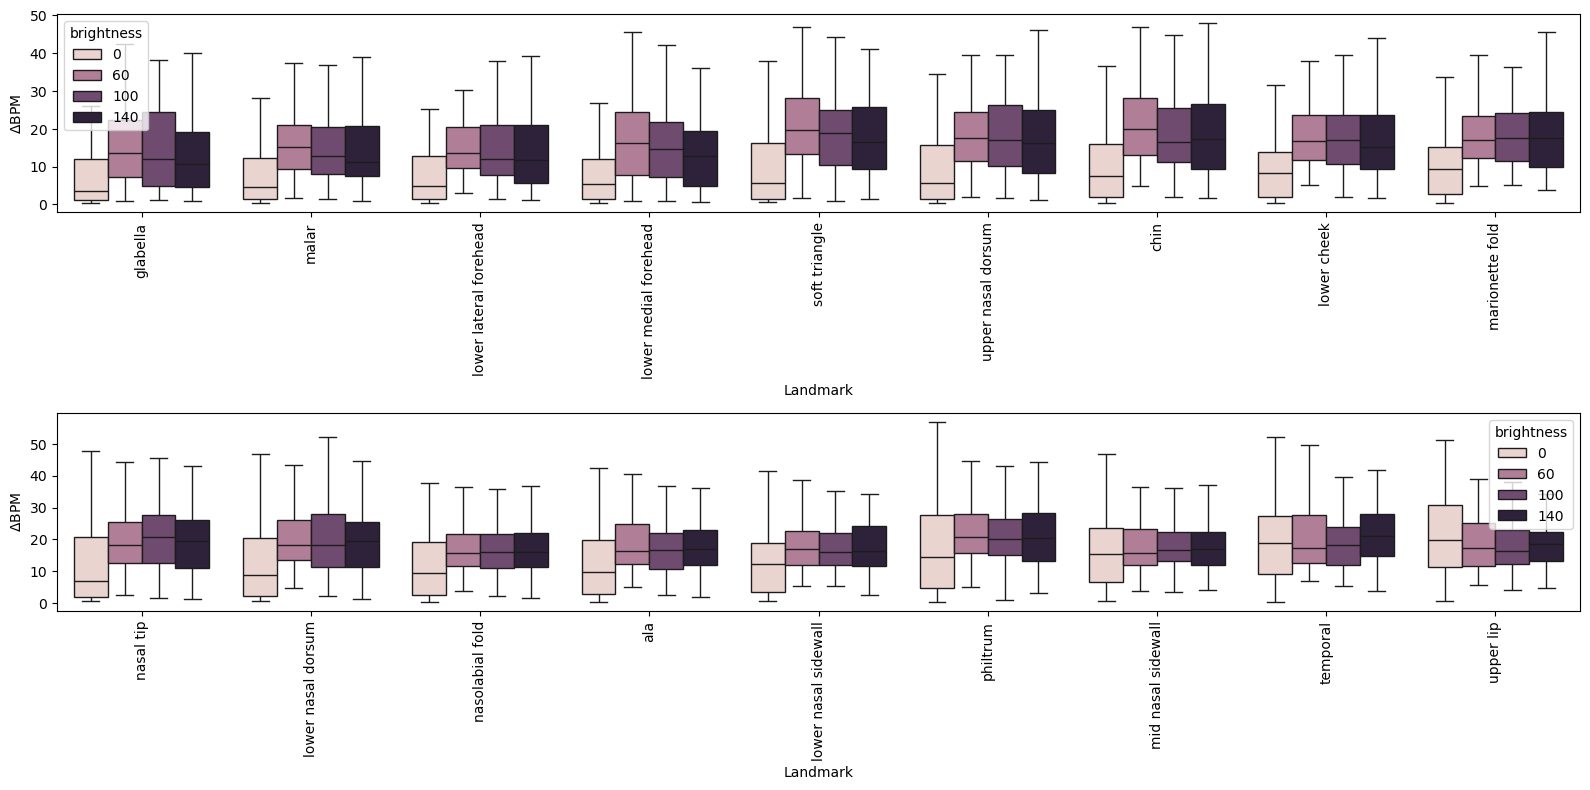

In [13]:
df, grouped, fig = compare_landmarks_brightness(['MR_NIRP', 'UBFC_PHYS', 'LGI_PPGI'])
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'median')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

Sampling - window - overlap:  ['2000_win10-0']
(396, 22) ROI:  ['forehead' 'nose' 'mustache' 'temple' 'cheeks' 'jaw'] 6
Landmarks:  18


<AxesSubplot: title={'center': 'MAE'}, xlabel='videoFilename'>

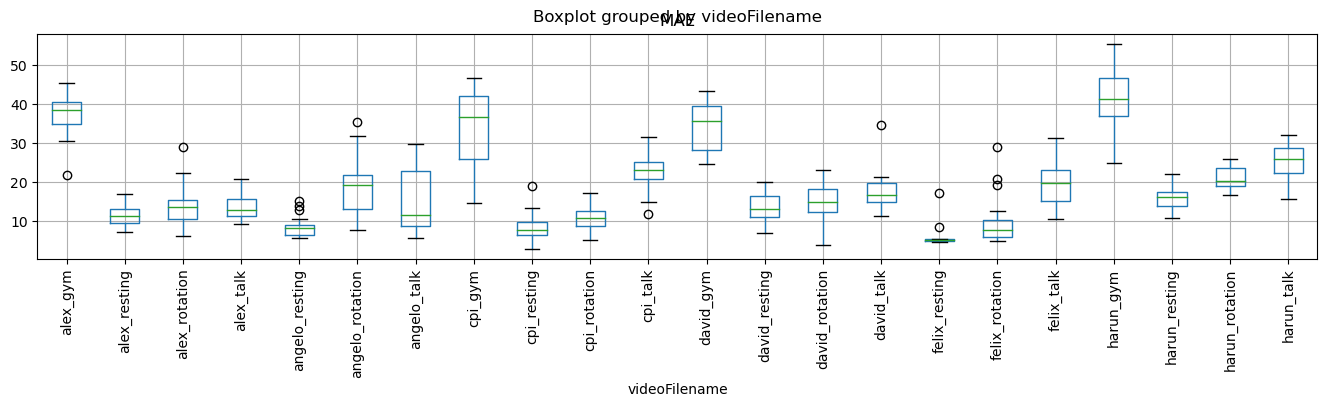

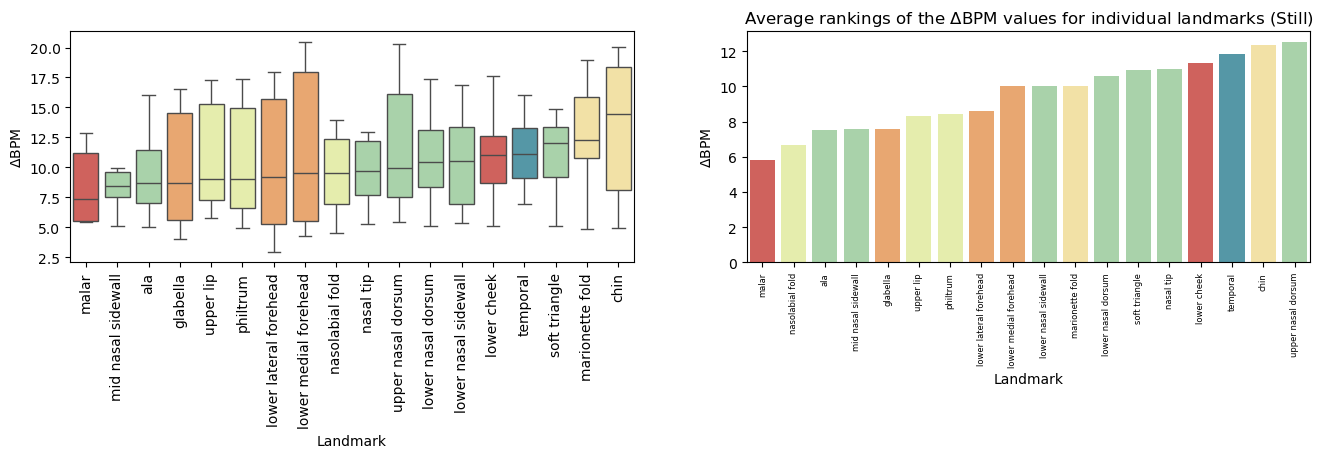

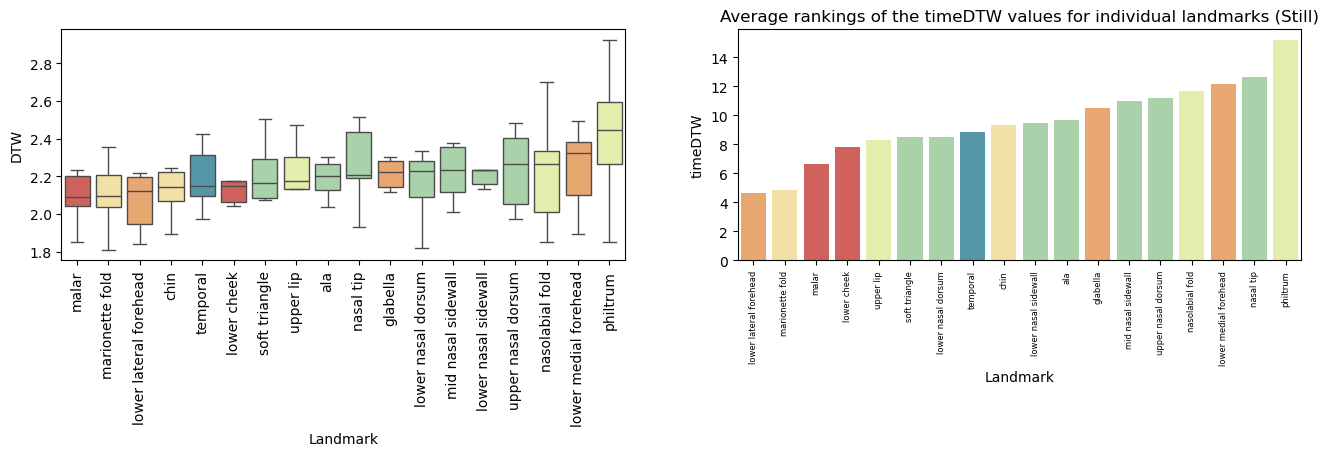

In [16]:
df = pd.read_hdf(f'../results/brightness_60/LGI_PPGI/LGI_PPGI_18.h5')
print("Sampling - window - overlap: ", df.config.unique())
df = df.query("method == 'cupy_CHROM'") # TODO
df = format_data(df).drop(columns=['config', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', ])
df = format_data_symmetric_landmark(df, symmetric=True) 
print(df.shape, "ROI: ", df.ROI.unique(), df.ROI.unique().size)
print("Landmarks: ", df.landmarks.unique().size)
df.head(1)

display(df.boxplot(column='MAE', by='videoFilename', figsize=(16,3), rot=90))

# Still
setting = 'Still'
x = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') | (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)

fig, axs = plt.subplots(1,2, figsize=(16,3))
_, grouped1, rankings1, _, _ = plot_each_landmark(x.copy(), 'MAE', dataset_name=setting, axs=axs)
fig, axs = plt.subplots(1,2, figsize=(16,3))
_, grouped1, rankings1, _, _ = plot_each_landmark(x.copy(), 'timeDTW', dataset_name=setting, axs=axs)

## Combinations

24 videos, 516 landmarks, (11380, 26)
Number of different landmarks combination 516


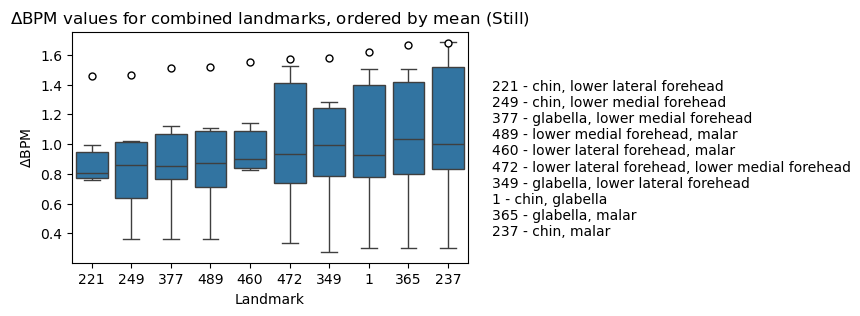

In [11]:
df = pd.DataFrame()
dataset_name = 'LGI_PPGI'
df = pd.concat([df, pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5')])
df = pd.concat([df, pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_combine_sym_landmarks.h5')])
df = pd.concat([df, pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_combine_sym_landmarks6-11.h5')])
df = df.query("method == 'cupy_CHROM'") # no need to do this but for fun
df['landmarks'] = df['landmarks'].apply(lambda x: tuple(sorted(x)))
df = format_data(df)
df['ROI'] = df['ROI'].apply(lambda x: '_'.join(sorted(x.split('_')))) # Sort ROI 
df = df[~df['landmarks'].apply(lambda x:
                              'lower_nasal_dorsum' in x or 'left_ala' in x or 'left_nasolabial_fold' in x or 'left_temporal' in x)].reset_index(drop=True)
# marionette fold not combined with lower nasal dorsum, ala, nasolabial fold
# 6-11 does not contain temporal, marionette fold
df = df.reset_index(drop=True).drop(columns=['bpmGT', 'bpmES', 'timeGT', 'timeES',])
df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
df['landmarks_names'] = df['landmarks'].apply(lambda x: set([name.replace('left_', '').replace('right_', '').strip() for name in x]))
df['landmarks_len'] = df['landmarks_names'].apply(lambda x: len(x))

print(f"{df.videoIdx.unique().size} videos, {df.landmarks.unique().size} landmarks, {df.shape}")
print("Number of different landmarks combination", df.landmarks_id.unique().size)
df.head(1)


x = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') | (df['dataset'] == 'ubfc_phys')].query('landmarks_len == 2').copy().reset_index(drop=True)
fig, ax = plt.subplots(1,1, figsize=(8,3))
y = plot_metric_rank2(x, 'MAE', 'Still', groupby_col='landmarks_id', top=10, agg_fct='mean', ax=ax, fig=fig)

In [7]:
df = pd.DataFrame()
dataset_name = 'LGI_PPGI'
# df = pd.concat([df, pd.read_hdf(f'../results/brightness_roi/lgi_mr/{dataset_name}/{dataset_name}_18.h5')])
df = pd.concat([df, pd.read_hdf(f'../results/brightness_roi/lgi_mr/{dataset_name}/{dataset_name}_combine_landmarks_2-6.h5')])
df = df.query("method == 'cupy_CHROM'") # no need to do this but for fun
df['landmarks'] = df['landmarks'].apply(lambda x: tuple(sorted(x)))
df = format_data(df)
df['ROI'] = df['ROI'].apply(lambda x: '_'.join(sorted(x.split('_')))) # Sort ROI 
df = df[~df['landmarks'].apply(lambda x:
                              'lower_nasal_dorsum' in x or 'left_ala' in x or 'left_nasolabial_fold' in x or 'left_temporal' in x)].reset_index(drop=True)
# marionette fold not combined with lower nasal dorsum, ala, nasolabial fold
# 6-11 does not contain temporal, marionette fold
df = df.reset_index(drop=True).drop(columns=['bpmGT', 'bpmES', 'timeGT', 'timeES',])
df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
df['landmarks_names'] = df['landmarks'].apply(lambda x: set([name.replace('left_', '').replace('right_', '').strip() for name in x]))
df['landmarks_len'] = df['landmarks_names'].apply(lambda x: len(x))

print(f"{df.videoIdx.unique().size} videos, {df.landmarks.unique().size} landmarks, {df.shape}")
print("Number of different landmarks combination", df.landmarks_id.unique().size)
df.head(1)

24 videos, 456 landmarks, (10944, 26)
Number of different landmarks combination 456


,dataset,videoIdx,videoFilename,landmarks,BVP_win,RMSE,MAE,PCC,timePCC,timeDTW,...,PCC_z,timePCC_z,timeDTW_z,FreqScore,TimeScore,score,OS,landmarks_id,landmarks_names,landmarks_len
0,lgi_ppgi,0,alex_gym,"(left_lower_lateral_forehead, right_lower_late...","[[[0.03796560254782869, -0.5747945892892348, -...",[24.70838020753408],24.401693,0.997871,0.003922,2.369055,...,0.002129,0.993394,0.507578,0.220461,0.750486,0.473186,0.646589,427,"{soft_triangle, lower_lateral_forehead}",2


,landmarks_id,landmarks,ROI,median,mean,std
0,48,"(chin, glabella, left_lower_lateral_forehead, ...",cheeks_forehead_jaw_nose,0.163206,0.162008,0.038901
1,62,"(chin, glabella, left_lower_lateral_forehead, ...",forehead_jaw_nose,0.176185,0.167234,0.042843
2,70,"(chin, glabella, left_malar, left_marionette_f...",cheeks_forehead_jaw_nose,0.154854,0.169451,0.074292
3,45,"(chin, glabella, left_lower_lateral_forehead, ...",cheeks_forehead_jaw_nose,0.156197,0.170284,0.066931
4,51,"(chin, glabella, left_lower_lateral_forehead, ...",cheeks_forehead_jaw_nose,0.159763,0.171581,0.033099
5,199,"(chin, left_malar, right_malar)",cheeks_jaw,0.171674,0.171923,0.043099
6,180,"(chin, left_lower_lateral_forehead, lower_medi...",forehead_jaw_nose,0.204768,0.174755,0.060684
7,118,"(chin, left_lower_cheek, left_lower_lateral_fo...",cheeks_forehead_jaw_nose,0.190855,0.175437,0.063722
8,125,"(chin, left_lower_cheek, left_malar, left_mari...",cheeks_forehead_jaw,0.174192,0.175796,0.069440
9,184,"(chin, left_lower_lateral_forehead, right_lowe...",forehead_jaw_nose,0.179048,0.176715,0.060193


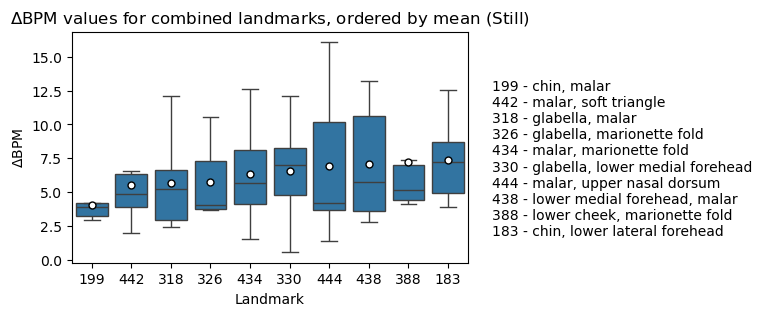

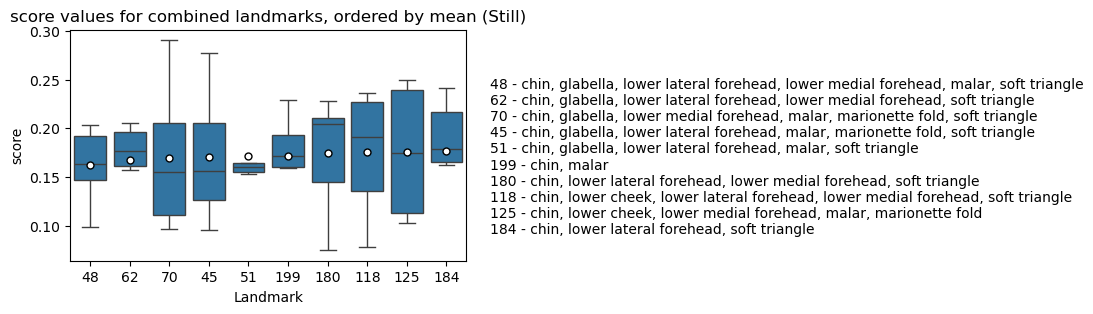

In [9]:
def plot_metric_rank2(df, metric, dataset_name, groupby_col='landmarks_id', top=10, agg_fct='mean', ax=None, fig=None):
    """ 
        Rank by overal mean/median metric and top 10. Plot metric. 
    """
    ascending = False if metric == 'PCC' else True 
    y = df.groupby([groupby_col, 'landmarks', 'ROI'])[metric].agg(['median','mean','std']).sort_values(by=agg_fct, ascending=ascending)[:top].reset_index()
    z = df[df[groupby_col].isin(y[groupby_col].unique())]
    if ax is None:
        return y

    box = sns.boxplot(x=groupby_col, y=metric, order=y.landmarks_id, data=z, showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}, showfliers=False)
    # box = sns.violinplot(x=groupby_col, y=metric,  order=y.landmarks_id, data=z, ax=ax)
    # box.legend_.remove()
    landmarks_mapping = y.sort_values(by=agg_fct, ascending=ascending)[['landmarks','landmarks_id']].drop_duplicates()
    landmarks_names = []
    for names in landmarks_mapping['landmarks'].values:
        names = [name.replace('left_', '').replace('right_', '').strip() for name in names]
        landmarks_names.append(', '.join([name.replace('_', ' ') for name in sorted(set(names))]))
    legend_text = '\n'.join(f'{key} - {value}' for key, value in zip(landmarks_mapping['landmarks_id'].values, landmarks_names))
    t = ax.text(.65,.2,legend_text,transform=ax.figure.transFigure)
    fig.subplots_adjust(right=.62)
    if metric == 'MAE': metric = r'$\Delta$' + 'BPM'
    box.set_xlabel('Landmark')
    box.set_ylabel(metric)
    title = f"{metric} values for combined landmarks, ordered by {agg_fct} ({dataset_name})"
    box.set_title(title)
    return y 

x = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') | (df['dataset'] == 'ubfc_phys')].query('landmarks_len == 2').copy().reset_index(drop=True)
fig, ax = plt.subplots(1,1, figsize=(8,3))
y = plot_metric_rank2(x, 'MAE', 'Still', groupby_col='landmarks_id', top=10, agg_fct='mean', ax=ax, fig=fig)

## Change soft triangle

## Compare performance

In [95]:
def __get_df(df):
    df = format_data(df).drop(columns=['config', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', ])
    df = format_data_symmetric_landmark(df, symmetric=True) 
    df['ldmk_MAE'] = df.groupby(['landmarks'])['MAE'].transform('mean')
    df['video_MAE'] = df.groupby(['videoFilename'])['MAE'].transform('mean') 
    return df

def __get_diff(df, dataset_name, groupby_col, metric):
    """
        groupby_col = 'videoFilename':  metric average for each video and brightness (over all landmarks)
        groupby_col = 'landmarks':  metric average for each landmark and brightness (over all videos)
    """
    diff = df.groupby([groupby_col, 'brightness'])[metric].mean().unstack() # metric for each video and brightness (all)
    diff['best'] = diff.idxmin(axis=1)
    diff['best'] = diff['best'].apply(lambda x: int(x))
    if groupby_col == 'videoFilename':
        x = pd.read_csv(f'../results/no_overlap/{dataset_name}/face_brightness.csv')
        diff = diff.merge(x.drop(columns=['dataset']), on='videoFilename', how='left') 

    return diff

def compare_brightness(dataset_name):
    df = __get_df(pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5').query("method == 'cupy_CHROM'"))
    df['brightness'] = 0
    levels = [60,100, 140]
    for level in levels:
        tmp = __get_df(pd.read_hdf(f'../results/brightness_{level}/{dataset_name}/{dataset_name}_18.h5'))
        tmp['brightness'] = level
        df = pd.concat([df, tmp], ignore_index=True) 
    video_diff = __get_diff(df,dataset_name, 'videoFilename', 'MAE')
    landmark_diff = __get_diff(df,dataset_name, 'landmarks', 'MAE')
    display(video_diff.loc[video_diff['best'] > 0])
    display(landmark_diff.loc[landmark_diff['best'] > 0])

    return video_diff, landmark_diff

In [96]:
df_all = pd.DataFrame()
for dataset_name in DATASETS:
    df = __get_df(pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5').query("method == 'cupy_CHROM'"))
    df['level'] = 0
    levels = [60,100, 140]
    for level in levels:
        tmp = __get_df(pd.read_hdf(f'../results/brightness_{level}/{dataset_name}/{dataset_name}_18.h5'))
        tmp['level'] = level
        df = pd.concat([df, tmp], ignore_index=True) 
    x = pd.read_csv(f'../results/no_overlap/{dataset_name}/face_brightness.csv')
    df = df.merge(x.drop(columns=['dataset']), on='videoFilename', how='left') 
    df_all = pd.concat([df_all, df], ignore_index=True) 

df_all['brightness'] = np.where(df_all['level'] == 0, df_all['brightness'], df_all['level'])


In [97]:
bins = range(20, 160, 20)  # Define bins from 0 to 100 with a step of 20
labels = [f'{i}-{i+20}' for i in bins[:-1]]  # Labels for the bins
metric = 'MAE'
df_all['brightness_group'] = pd.cut(df_all['brightness'], bins=bins, labels=labels, right=False)
diff = df_all.groupby(['videoFilename', 'landmarks', 'brightness_group'])[metric].apply('min').unstack() # metric for each video and brightness (all)
diff['best'] = diff.idxmin(axis=1)
ldmk_bin = diff.groupby('landmarks')['best'].value_counts().reset_index(name='count')
nb_files_group = df_all['brightness_group'].value_counts()
ldmk_bin['total'] = (ldmk_bin['best'].map(nb_files_group)).astype(int)
ldmk_bin['frac'] = ldmk_bin['count'] / ldmk_bin['total']

In [98]:
pd.crosstab(index=ldmk_bin['landmarks'], columns=ldmk_bin['best'], values=ldmk_bin['count'], aggfunc='sum', normalize='index').style.background_gradient(cmap='viridis', axis=1)

best,20-40,40-60,60-80,80-100,100-120,120-140
landmarks,,,,,,
ala,0.011364,0.011364,0.181818,0.056818,0.420455,0.318182
chin,0.011364,0.022727,0.170455,0.068182,0.340909,0.386364
glabella,0.011364,0.022727,0.238636,0.056818,0.340909,0.329545
lower_cheek,0.011364,0.022727,0.204545,0.090909,0.295455,0.375000
lower_lateral_forehead,0.011364,0.034091,0.159091,0.079545,0.363636,0.352273
lower_medial_forehead,0.011364,0.022727,0.170455,0.056818,0.397727,0.340909
lower_nasal_dorsum,0.011364,0.034091,0.227273,0.068182,0.340909,0.318182
lower_nasal_sidewall,0.011364,0.022727,0.204545,0.068182,0.397727,0.295455
malar,0.011364,0.022727,0.159091,0.056818,0.352273,0.397727


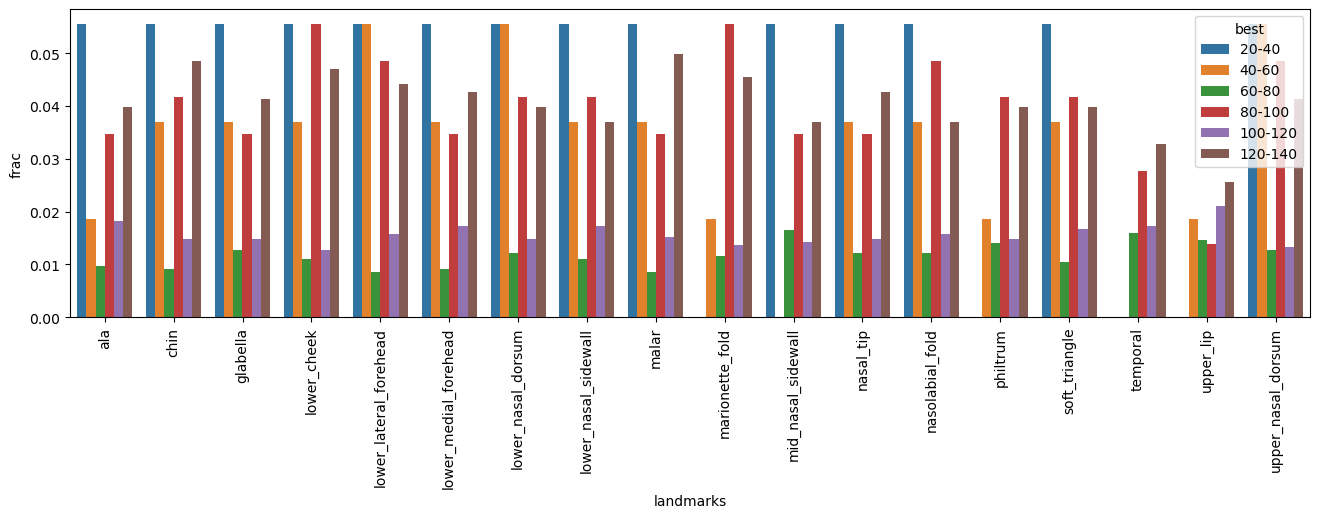

In [99]:
plt.figure(figsize=(16,4))
sns.barplot(data=ldmk_bin, x='landmarks', y='frac', hue='best')
plt.xticks(rotation=90)
plt.show()

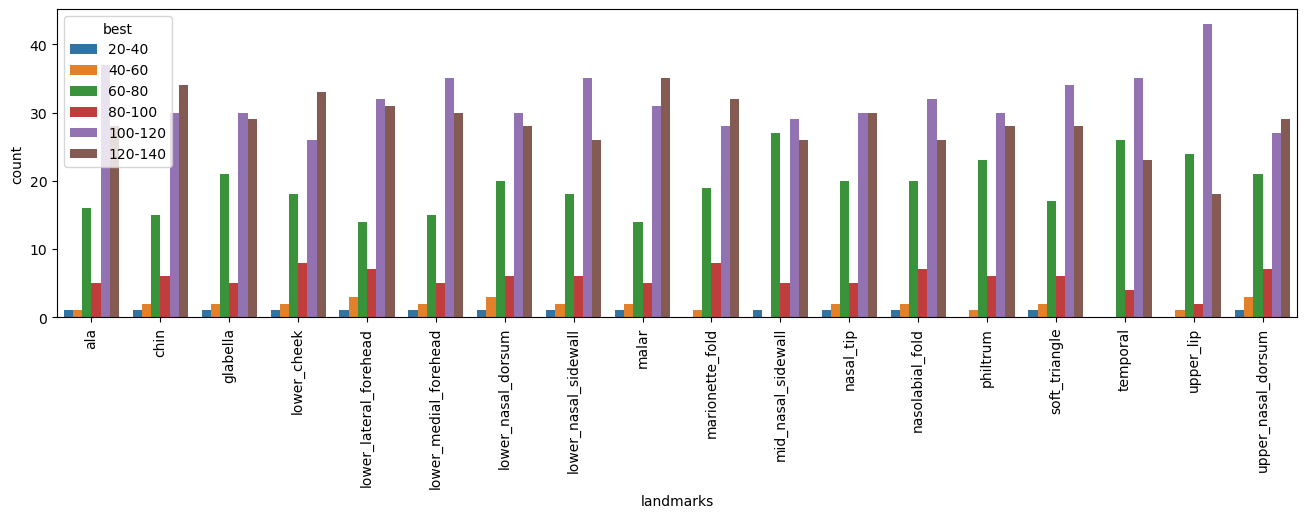

In [101]:
plt.figure(figsize=(16,4))
sns.barplot(data=ldmk_bin, x='landmarks', y='count', hue='best')
plt.xticks(rotation=90)
plt.show()

In [102]:
dataset_name = 'LGI_PPGI'
df = __get_df(pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5').query("method == 'cupy_CHROM'"))
df['brightness'] = 20
levels = [60,100]
for level in levels:
    tmp = __get_df(pd.read_hdf(f'../results/brightness_{level}/{dataset_name}/{dataset_name}_18.h5'))
    tmp['brightness'] = level
    df = pd.concat([df, tmp], ignore_index=True) 

In [103]:
# for each video and landmark, best brightness
groupby_col = 'videoFilename'
metric = 'MAE'
diff = df.groupby([groupby_col, 'landmarks', 'brightness'])[metric].apply('min').unstack() # metric for each video and brightness (all)
diff['best'] = diff.idxmin(axis=1).apply(lambda x: int(x))
df = df.sort_values([groupby_col, 'landmarks', 'MAE'])[['videoFilename', 'brightness', 'MAE', 'landmarks']]
df = df.merge(diff['best'], on=['videoFilename', 'landmarks'], how='left').sort_values(['videoFilename', 'landmarks', 'MAE']).drop_duplicates(['videoFilename', 'landmarks'])
x = pd.read_csv(f'../results/no_overlap/{dataset_name}/face_brightness.csv')
df = df.merge(x.drop(columns=['dataset']).rename({'brightness':'video_brightness'}, axis=1), on='videoFilename', how='left') 
df['best_brightness'] = df.apply(lambda x: x['brightness'] if x['best'] > 0 else x['video_brightness'], axis=1)
df['brighter_better'] = df['best'] > 0
df.query('best > 0').drop_duplicates(['videoFilename','landmarks'])

,videoFilename,brightness,MAE,landmarks,best,video_brightness,best_brightness,brighter_better
0,alex_gym,20,23.774414,ala,20,105.685542,20,True
1,alex_gym,20,32.318034,chin,20,105.685542,20,True
2,alex_gym,20,23.451497,glabella,20,105.685542,20,True
3,alex_gym,20,28.348145,lower_cheek,20,105.685542,20,True
4,alex_gym,20,31.319336,lower_lateral_forehead,20,105.685542,20,True
...,...,...,...,...,...,...,...,...
427,harun_talk,20,22.855143,philtrum,20,135.032223,20,True
428,harun_talk,60,30.980143,soft_triangle,60,135.032223,60,True
429,harun_talk,20,6.016764,temporal,20,135.032223,20,True
430,harun_talk,60,19.812012,upper_lip,60,135.032223,60,True


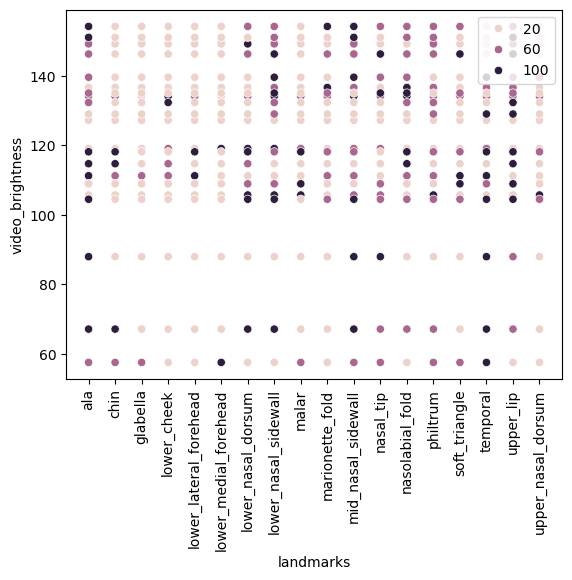

In [104]:
sns.scatterplot(x='landmarks', y='video_brightness',data=df.query('best > 0'), hue='best')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

In [105]:
dataset_name = 'LGI_PPGI'
df = __get_df(pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5').query("method == 'cupy_CHROM'"))
df['brightness'] = 0
levels = [60,100]
for level in levels:
    tmp = __get_df(pd.read_hdf(f'../results/brightness_{level}/{dataset_name}/{dataset_name}_18.h5'))
    tmp['brightness'] = level
    df = pd.concat([df, tmp], ignore_index=True) 

ldmks = ['lower_lateral_forehead', 'marionette_fold', 'chin', 'lower_medial_forehead', 'upper_nasal_dorsum', 'soft_triangle', 'glabella', 'malar', 'lower_cheek']
# best landmarks: for each video, if the brightned version was best
df.loc[df['landmarks'].isin(ldmks)].sort_values(['videoFilename', 'MAE']).drop_duplicates(['videoFilename'], keep='first').query('brightness > 0')[['videoFilename', 'brightness', 'MAE', 'landmarks']]
# for the best landmarks: for each video, how many times the brightned version was best
# df.loc[df['landmarks'].isin(ldmks)].sort_values(['videoFilename','landmarks',  'MAE']).drop_duplicates(['videoFilename', 'landmarks'], keep='first').query('brightness > 0')[['videoFilename', 'brightness', 'MAE', 'landmarks']]

,videoFilename,brightness,MAE,landmarks
719,felix_resting,60,4.836263,marionette_fold
1135,felix_talk,100,7.650065,lower_lateral_forehead


In [107]:
# for each video and landmark, best brightness
diff = df.groupby([groupby_col, 'landmarks', 'brightness'])[metric].apply('min').unstack() # metric for each video and brightness (all)
diff['best'] = diff.idxmin(axis=1).apply(lambda x: int(x))
df = df.sort_values([groupby_col, 'landmarks', 'MAE'])[['videoFilename', 'brightness', 'MAE', 'landmarks']]
df = df.merge(diff['best'], on=['videoFilename', 'landmarks'], how='left').sort_values(['videoFilename', 'landmarks', 'MAE'])
df.query('best > 0').drop_duplicates(['videoFilename','landmarks'])

,videoFilename,brightness,MAE,landmarks,best
18,alex_gym,100,35.733398,lower_nasal_dorsum,100
21,alex_gym,100,24.075684,lower_nasal_sidewall,100
24,alex_gym,100,26.024414,malar,100
30,alex_gym,60,21.703613,mid_nasal_sidewall,60
33,alex_gym,60,45.132812,nasal_tip,60
...,...,...,...,...,...
1197,harun_talk,60,17.736816,marionette_fold,60
1203,harun_talk,100,17.627604,nasal_tip,100
1206,harun_talk,100,16.392741,nasolabial_fold,100
1212,harun_talk,60,30.980143,soft_triangle,60


In [108]:
# min error landmark video
groupby_col = 'videoFilename'
metric = 'MAE'
diff = df.groupby([groupby_col, 'brightness'])[metric].apply('min').unstack() # metric for each video and brightness (all)
diff['best'] = diff.idxmin(axis=1).apply(lambda x: int(x))
df = df.sort_values([groupby_col, 'MAE']).drop_duplicates([groupby_col, 'brightness'], keep='first')[['videoFilename', 'brightness', 'MAE', 'landmarks']]
df = df.merge(diff['best'], on='videoFilename', how='left').sort_values([groupby_col, 'MAE'])
df.query('best > 0').drop_duplicates(groupby_col)

,videoFilename,brightness,MAE,landmarks,best
31,cpi_talk,60,11.777507,ala,60
47,felix_resting,60,4.531087,nasolabial_fold,60
53,felix_talk,100,7.650065,lower_lateral_forehead,100


In [109]:
dataset_name = 'MR_NIRP'
video_diff, landmark_diff = compare_brightness(dataset_name)

,videoFilename,0,60,100,140,best,brightness


brightness,0,60,100,140,best
landmarks,,,,,
philtrum,25.749593,20.414958,20.248372,20.074626,140
temporal,20.594767,16.469279,16.886759,22.713216,60
upper_lip,30.115967,13.492513,13.585815,16.947469,60


In [110]:
dataset_name = 'LGI_PPGI'
video_diff, landmark_diff = compare_brightness(dataset_name)

,videoFilename,0,60,100,140,best,brightness
1,alex_resting,15.744548,11.677445,14.918792,13.882351,60,139.583053
2,alex_rotation,14.540500,14.420709,15.939055,14.519170,60,118.735087
3,alex_talk,23.466182,13.615488,18.434579,19.803584,60,134.113538
4,angelo_gym,34.731644,NaN,NaN,34.464392,140,127.194800
6,angelo_rotation,13.056080,18.992414,12.892804,16.248969,100,149.430715
7,angelo_talk,21.671667,14.757577,16.588198,17.736355,60,67.080684
9,cpi_resting,10.009341,8.296342,8.238290,8.684462,100,149.183808
10,cpi_rotation,12.075982,11.182907,12.646756,13.981518,60,151.058641
11,cpi_talk,24.199472,22.385073,25.126121,26.266891,60,57.488957
13,david_resting,16.025933,13.588135,14.014938,14.084500,60,154.209330


brightness,0,60,100,140,best
landmarks,,,,,
ala,22.108480,18.226341,17.375185,18.186293,100
lower_nasal_dorsum,22.659587,19.524902,21.070594,21.690484,60
lower_nasal_sidewall,23.810757,16.980898,17.354218,18.516690,60
mid_nasal_sidewall,23.651815,16.092729,16.394746,17.753330,60
nasal_tip,24.888699,21.354625,23.659535,23.457221,60
nasolabial_fold,21.582038,17.326290,18.817168,19.522983,60
philtrum,29.015964,20.122366,24.114480,25.020128,60
soft_triangle,21.778347,21.790897,20.575447,21.117730,100
temporal,21.208483,20.889301,18.407160,21.186896,100


In [111]:
dataset_name = 'UBFC_PHYS'
video_diff, landmark_diff = compare_brightness(dataset_name)

,videoFilename,0,60,100,140,best,brightness
6,s15,41.467081,28.449490,28.328514,30.627035,100,126.771056
14,s22,15.117059,14.257035,15.220450,15.868562,60,109.839438
18,s26,34.790191,30.566949,33.141439,33.920166,60,99.090460
26,s33,31.203924,16.633672,21.324508,21.109691,60,129.745947
48,s53,11.662574,12.912607,12.390824,11.519115,140,127.015017
54,s8,15.067380,13.554000,15.880434,15.449345,60,118.323474
55,s9,30.915302,31.029668,29.857359,34.538249,100,136.407247


brightness,0,60,100,140,best
landmarks,,,,,


<AxesSubplot: title={'center': 'UBFC_PHYS'}, xlabel='brightness'>

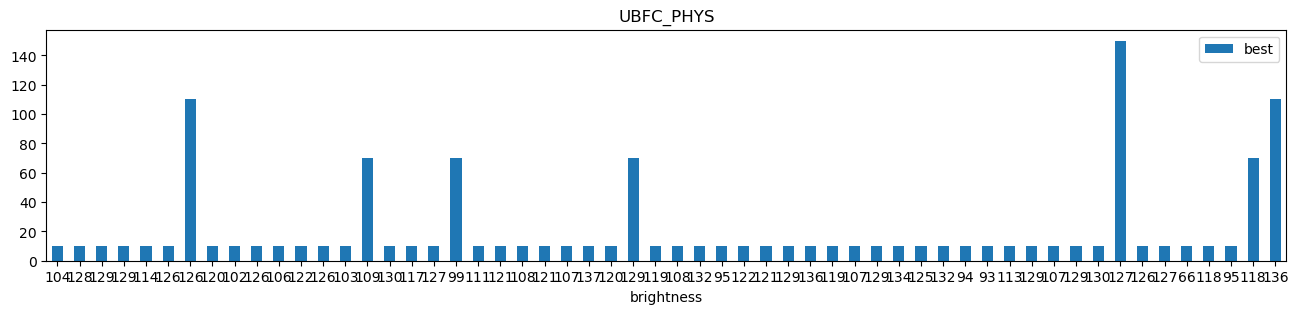

In [112]:
video_diff['brightness'] = video_diff['brightness'].astype(int)
video_diff['best'] = video_diff['best'] + 10
video_diff.plot(x='brightness', y='best', kind='bar', figsize=(16,3), rot=0, title=dataset_name)

# ROI Brightness

In [4]:
import ast 

df_roi, df = pd.DataFrame(), pd.DataFrame()
for dataset_name in ['LGI_PPGI', 'MR_NIRP']:
    df_roi = pd.read_csv(f'../results/no_overlap/{dataset_name}/roi_brightness.csv')
    df_video = pd.read_csv(f'../results/no_overlap/{dataset_name}/face_brightness.csv')
    for roi in df_roi.columns[2:]:
        df_roi[roi] = df_roi[roi].apply(lambda x: np.mean(ast.literal_eval(x)))

    tmp = pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_28.h5').drop(columns=['bpmGT', 'bpmES', 'BVP_win', 'timeGT','timeES', 'config'])
    tmp['landmarks'] = tmp['landmarks'].apply(lambda x: x[0])
    # merge df_roi to df by matching values in the column 'landmarks' in df to the column names in df_roi
    tmp = tmp.merge(df_roi.melt(id_vars=['videoFilename','dataset'], var_name='landmarks', value_name='ldmk_brightness'), on=['dataset','videoFilename', 'landmarks'], how='left')
    tmp = tmp.merge(df_video.rename({'brightness':'video_brightness'},axis=1), on=['videoFilename','dataset'], how='left')
    df = pd.concat([df, tmp], ignore_index=True)

df['MAE'] = df['MAE'].apply(lambda x: x[0])
datasets = df['dataset'].unique()
df['datasets'] = df['dataset'].apply(lambda x: datasets)

# # for now just consider resting 
# # df_roi = df_roi.query('videoFilename.str.contains("resting")', engine='python')
# # df = df.query('videoFilename.str.contains("resting")', engine='python')

# rename the left and right components as one landmark
df['landmarks'] = df['landmarks'].apply(lambda x: x.replace('left_', '').replace('right_', ''))

# bin brightness values and calculate the average MAE for each bin
df['ldmk_brightness_bin'] = pd.cut(df['ldmk_brightness'], bins=[0,100,140,220], labels=['-100', '100-140','140-'], right=False)
df['mae_brightness_bin'] = df.groupby(['landmarks', 'ldmk_brightness_bin'])['MAE'].transform('mean').apply(lambda x: round(x, 2))

# groupby landmarks, ldmk_brightness_bin that gave the best MAE on average
ldmk_best_brightness = df.groupby(['landmarks', 'ldmk_brightness_bin'])['MAE'].mean().unstack().idxmin(axis=1).reset_index(name='best_ldmk_brightness')
df = df.merge(ldmk_best_brightness, on='landmarks', how='left')
brightness_target = {'-100':80, '140-':160, '100-140':120}
df['target'] = df['best_ldmk_brightness'].apply(lambda x: brightness_target[x])

df.head(1)

,dataset,videoIdx,videoFilename,method,landmarks,RMSE,MAE,PCC,timePCC,timeDTW,SNR,ROI,ldmk_brightness,video_brightness,datasets,ldmk_brightness_bin,mae_brightness_bin,best_ldmk_brightness,target
0,lgi_ppgi,0,alex_gym,cupy_CHROM,lower_medial_forehead,[19.20279927775441],11.500651,[0.9215972585777074],0.077629,2.009835,[-4.055627882480621],forehead,121.594144,105.685542,"[lgi_ppgi, mr_nirp]",100-140,5.52,-100,80


In [143]:
df.query('ldmk_brightness_bin == best_ldmk_brightness', engine='python').drop_duplicates(['landmarks'])[['landmarks', 'best_ldmk_brightness', 'mae_brightness_bin', 'target']]

,landmarks,best_ldmk_brightness,mae_brightness_bin,target
14,philtrum,100-140,25.23,120
15,upper_lip,100-140,25.30,120
31,glabella,140-,5.30,160
41,mid_nasal_sidewall,140-,19.06,160
47,temporal,-100,22.85,80
53,chin,140-,4.62,160
55,marionette_fold,140-,5.42,160
119,ala,-100,15.09,80
122,lower_nasal_sidewall,-100,16.31,80
129,nasolabial_fold,-100,16.00,80


In [8]:
import plotly.express as px
# plot roi_brightness on x axis with the MAE on y axis, color coded by landmarks
fig = px.scatter(df, x='ldmk_brightness', y='MAE', color='landmarks', hover_data=['landmarks', 'videoFilename'])
fig.show()

In [21]:
# x = df.query('ldmk_brightness_bin == best_ldmk_brightness', engine='python').drop_duplicates(['landmarks'])[['landmarks', 'best_ldmk_brightness', 'mae_brightness_bin', 'target', 'datasets']].copy()
# x['target'] = 120
# x['datasets'] = 'custom_120'
# x.to_csv(f'../results/brightness_roi/roi_120/best_roi_brightness.csv', index=False)

In [145]:
df.query('ldmk_brightness_bin == best_ldmk_brightness', engine='python').drop_duplicates(['landmarks'])[['landmarks', 'best_ldmk_brightness', 'mae_brightness_bin', 'target', 'datasets']]\
    .to_csv(f'../results/brightness_roi/lgi_mr/best_roi_brightness.csv', index=False)

# Enhanced by ROI

- LGI: Used only LGI videos to get the heuristic for brightness
- LGI-MR: Used LGI and MRNIRP videos 

In [155]:
def __get_df(df):
    df = format_data(df).drop(columns=['config', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', ])
    df = format_data_symmetric_landmark(df, symmetric=False) 
    df['ldmk_MAE'] = df.groupby(['landmarks'])['MAE'].transform('mean')
    df['video_MAE'] = df.groupby(['videoFilename'])['MAE'].transform('mean') 


    return df

def compare_asym_landmarks_brightness(dataset_name):
    """
        Plot boxplot of asymmetrical landmarks by brightness levels
        Brightness adjusted by heuristics per ROI
    """
    df = __get_df(pd.read_hdf(f'../results/brightness_roi/LGI_PPGI_28_baseline.h5').query("method == 'cupy_CHROM'"))
    df['brightness'] = 0
    dataset_name = 'LGI_PPGI'
    levels = ['lgi', 'lgi_mr']
    top_landmarks_asym = ['left_malar','right_malar', 'left_lower_cheek','right_lower_cheek', 'soft_triangle','upper_nasal_dorsum', 'lower_medial_forehead','glabella',
                        'left_lower_lateral_forehead', 'right_lower_lateral_forehead', 'chin', 'left_marionette_fold', 'right_marionette_fold']

    for level in levels:
        tmp =  __get_df(pd.read_hdf(f'../results/brightness_roi/{level}/{dataset_name}/{dataset_name}_28.h5'))
        tmp['brightness'] = level
        df = pd.concat([df, tmp], ignore_index=True) 
    # df = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') | (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)
    print("Brightness levels: " , df.brightness.unique())

    groupby_col, metric = ['landmarks', 'brightness'], 'MAE'
    grouped = df[['landmarks', 'brightness','MAE']].groupby(groupby_col).median()
    grouped_original = grouped.reset_index(level=1).query('brightness == 0').copy() # sort by median
    df_good = df[df['landmarks'].isin(top_landmarks_asym)].copy()
    df_bad = df[~df['landmarks'].isin(top_landmarks_asym)].copy()

    def boxplot_landmarks(df, grouped, metric, ax):
        box = sns.boxplot(x='landmarks', y=metric, data=df.sort_values(['ROI', 'brightness']), hue='brightness', ax=ax, showfliers=False,)
        labels = [item.get_text().replace('_', ' ')  for item in box.get_xticklabels()]
        box.set_xticks(range(len(labels)))
        box.set_xticklabels(labels,rotation=90, fontsize=10)
        if metric == 'MAE': metric = r'$\Delta$' + 'BPM'
        if metric == 'timeDTW': metric = 'DTW'
        if metric == 'score': metric = 'OS'
        box.set_xlabel('Landmark')
        box.set_ylabel(metric)
        return box

    fig, ax = plt.subplots(2,1, figsize=(16,8))
    box1 = boxplot_landmarks(df_good, grouped_original.loc[grouped_original.index.get_level_values('landmarks').isin(top_landmarks_asym)], 'MAE', ax[0])
    box2 = boxplot_landmarks(df_bad, grouped_original.loc[~grouped_original.index.get_level_values('landmarks').isin(top_landmarks_asym)], 'MAE', ax[1])
    plt.tight_layout()

    return df, grouped, fig

Brightness levels:  [0 'lgi' 'lgi_mr']


landmarks brightness        MAE           
                                                  mean     median
0                       glabella          0   7.840095   3.355794
1          lower_medial_forehead          0   8.690740   6.675293
2   right_lower_lateral_forehead          0   9.010062   5.060221
3                    right_malar          0  10.111802   5.249023
4              right_lower_cheek          0  12.100630   6.128092
5    left_lower_lateral_forehead          0  12.596561   7.790690
7                           chin          0  12.896262   8.296387
8             upper_nasal_dorsum          0  12.903927   9.427572
9                     left_malar          0  12.964341   9.875000
13         right_marionette_fold          0  14.361565  11.736491
15                     nasal_tip     lgi_mr  15.227901  13.163411
18         right_nasolabial_fold     lgi_mr  15.550673  16.909180
20              left_lower_cheek          0  15.668649  14.147298
21                      philtrum     lgi_mr  15.867296  14.356120
22    right_lower_nasal_sidewall     lgi_mr  16.335684  15.242513
24                 soft_triangle     lgi_mr  17.027416  16.011068
27                left_upper_lip     lgi_mr  17.451208  18.724935
31      right_mid_nasal_sidewall     lgi_mr  17.916305  17.998372
35          left_nasolabial_fold     lgi_mr  18.726924  17.027995
39          left_marionette_fold          0  19.187589  20.575358
40                right_temporal     lgi_mr  19.376989  18.402018
42               right_upper_lip     lgi_mr  20.654586  19.509115
43                     right_ala     lgi_mr  20.977792  21.226237
50            lower_nasal_dorsum          0  22.107363  19.366048
52       left_mid_nasal_sidewall        lgi  22.411811  20.452474
55                 left_temporal     lgi_mr  22.485062  21.477214
56     left_lower_nasal_sidewall     lgi_mr  22.557798  21.017904
64                      left_ala     lgi_mr  24.096029  17.180990

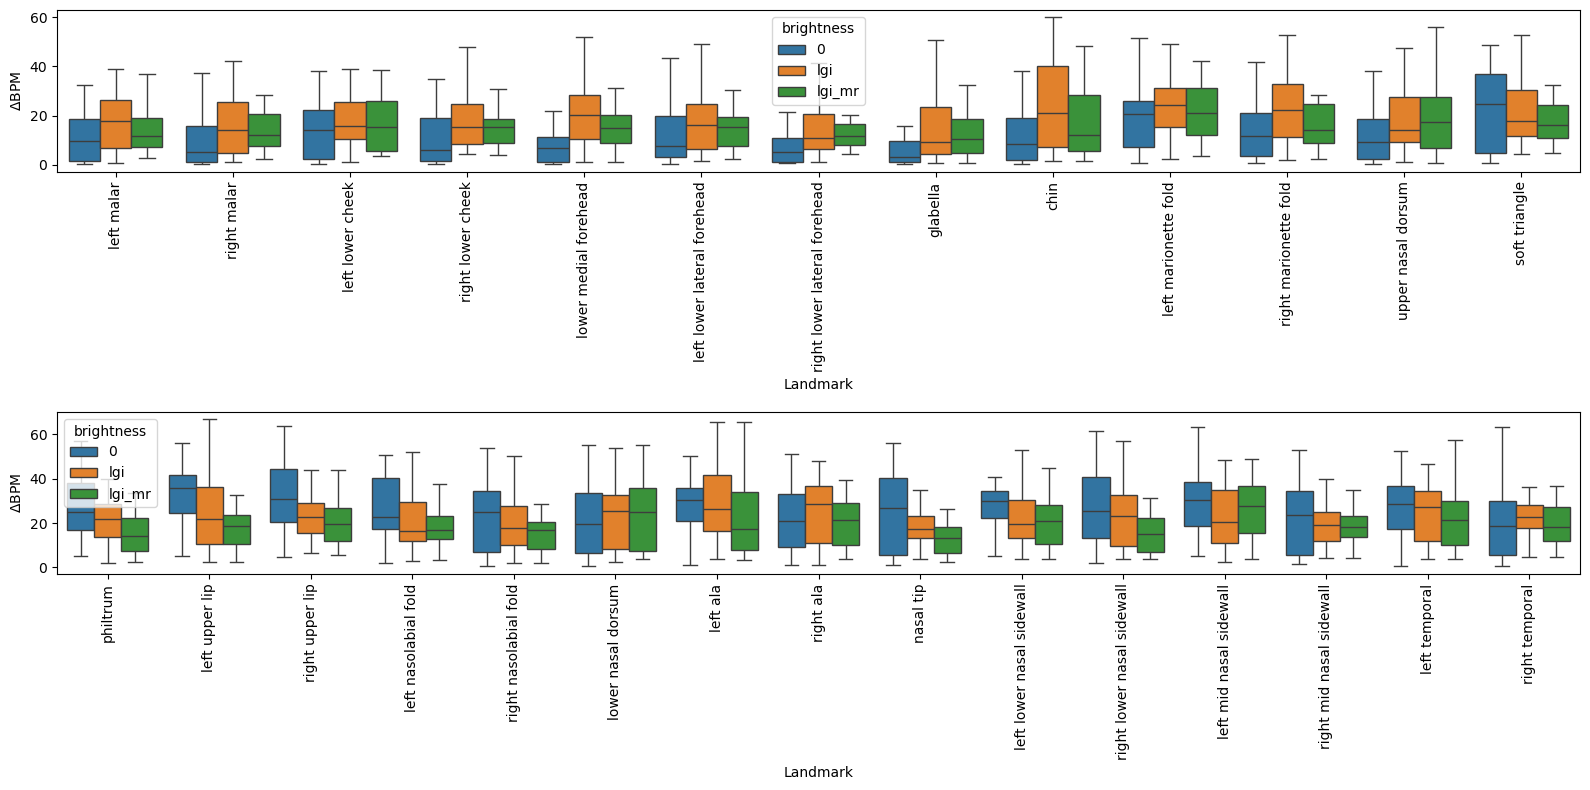

In [156]:
df, grouped, fig = compare_asym_landmarks_brightness('LGI_PPGI')
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'mean')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

# Brightness of video 

In [164]:
df = pd.DataFrame()
for dataset_name in DATASETS:
    df = pd.concat([df, pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5')])
print("Sampling - window - overlap: ", df.config.unique())
df = df.query("method == 'cupy_CHROM'") # TODO
df = format_data(df).drop(columns=['config', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', ])
df = format_data_symmetric_landmark(df, symmetric=True) 
df = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') & df['videoFilename'].str.contains('still')
        | (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)

print(df.shape, "ROI: ", df.ROI.unique(), df.ROI.unique().size)
print("Landmarks: ", df.landmarks.unique().size)
df.head(1)

Sampling - window - overlap:  ['2000_win10-0']
(1260, 22) ROI:  ['forehead' 'nose' 'mustache' 'temple' 'cheeks' 'jaw'] 6
Landmarks:  18


,dataset,videoIdx,videoFilename,landmarks,bpmGT,bpmES,timeGT,timeES,BVP_win,RMSE,...,timePCC,timeDTW,SNR,ROI,video,person,FreqScore,TimeScore,score,OS
0,lgi_ppgi,1,alex_resting,lower_medial_forehead,"[68.5, 68.0, 68.0, 67.5, 67.0, 67.0, 66.5, 66....","[68.115234375, 63.720703125, 65.91796875, 68.1...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.0018437893949923298, -0.1971926391704808...",[0.6623081145314609],...,0.014376,1.951776,[5.035702139139175],forehead,resting,alex,0.003175,0.655885,0.167383,0.438365


In [188]:
# Brightness 
df_data = pd.DataFrame()
for dataset_name in DATASETS:
    # df_data = pd.concat([df_data, pd.read_csv(f'../results/no_overlap/{dataset_name}/{dataset_name}_brightness.csv')])
    df_data = pd.concat([df_data, pd.read_csv(f'../results/brightness_60/{dataset_name}/face_brightness.csv')])
df = df.merge(df_data, on=['dataset', 'videoFilename'], how='left')
df_data['dataset'] = df_data['dataset'].apply(lambda x: x.replace('_', '-').upper())
df_data.drop_duplicates('dataset').head()

,dataset,videoFilename,brightness
0,LGI-PPGI,alex_gym,105.685542
0,MR-NIRP,Subject1_still_940,45.029081
0,UBFC-PHYS,s1,104.912960


<AxesSubplot: xlabel='videoFilename'>

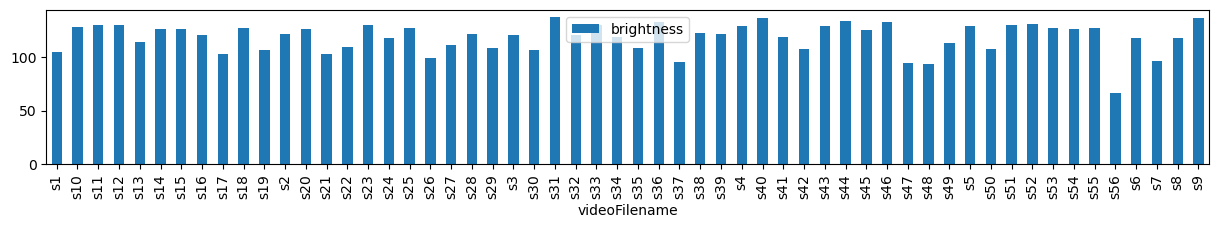

In [199]:
df_data.query('dataset == "UBFC-PHYS"').plot.bar(y='brightness', x='videoFilename', figsize=(15,2))

C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\1220280030.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\1220280030.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\1220280030.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

Text(0, 0.5, '$\\Delta$BPM')

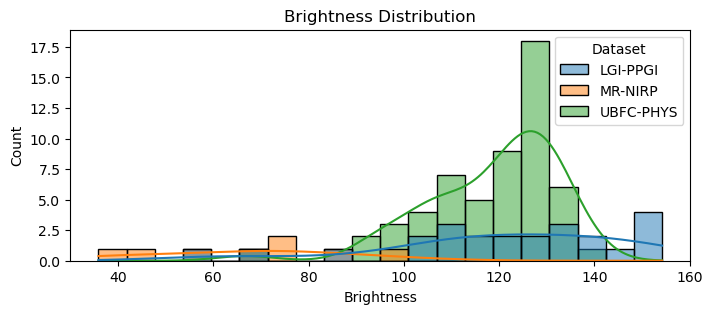

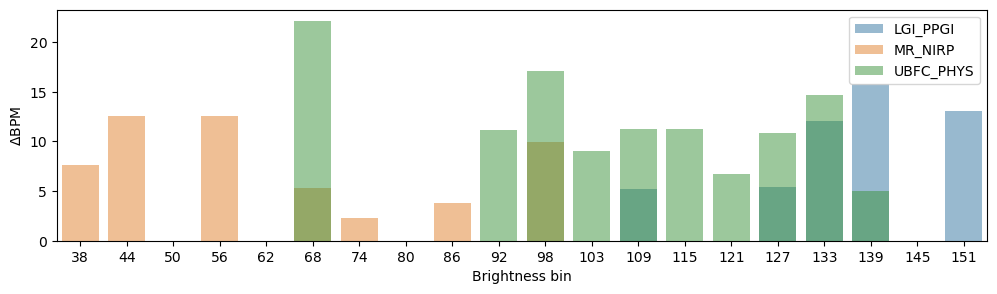

In [180]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
sns.histplot(data=df_data.rename(columns={'brightness':'Brightness', 'dataset':'Dataset'}), x='Brightness', hue='Dataset', bins=20, kde=True, ax=ax)
ax.set_title('Brightness Distribution')

fig, ax = plt.subplots(1,1, figsize=(12,3))
bins = 20
df['brightness_bin'] = pd.cut(df['brightness'], bins=bins)
for dataset_name in DATASETS:
    tmp = df.query(f"dataset == '{dataset_name.lower()}'").copy()
    # tmp['brightness_bin'] = pd.cut(tmp['brightness'], bins=bins)
    tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
    # tmp['std'] = tmp['std'].fillna(0)
    tmp['bin'] = tmp['brightness_bin'].apply(lambda x: int(x.mid)) 

    sns.barplot(x='bin', y='mean', data=tmp, ax=ax, alpha=0.5, label=dataset_name)
ax.set_xlabel('Brightness bin')
ax.set_ylabel(r'$\Delta$' + 'BPM')
# ax.set_xticks([ 40.,  60.,  80., 100., 120., 140., 160., 180., 200., 220.])

C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\926202968.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\926202968.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\926202968.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

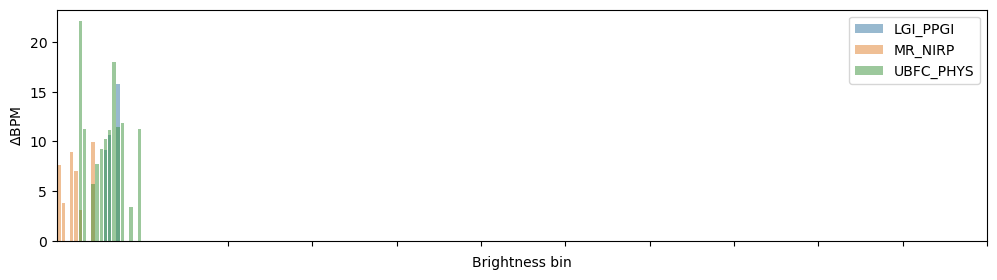

In [130]:
fig, ax = plt.subplots(1,1, figsize=(12,3))
bins = 20
df['brightness_bin'] = pd.cut(df['brightness'], bins=bins)
for dataset_name in DATASETS:
    tmp = df.query(f"dataset == '{dataset_name.lower()}'").copy()
    # tmp['brightness_bin'] = pd.cut(tmp['brightness'], bins=bins)
    tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
    # tmp['std'] = tmp['std'].fillna(0)
    tmp['bin'] = tmp['brightness_bin'].apply(lambda x: int(x.mid)) 

    sns.barplot(x='bin', y='mean', data=tmp, ax=ax, alpha=0.5, label=dataset_name)
ax.set_xlabel('Brightness bin')
ax.set_ylabel(r'$\Delta$' + 'BPM')
ax.set_xticks([ 40.,  60.,  80., 100., 120., 140., 160., 180., 200., 220.])x

C:\Users\erolland\AppData\Local\Temp\3\ipykernel_50976\4154918087.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_50976\4154918087.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_50976\4154918087.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

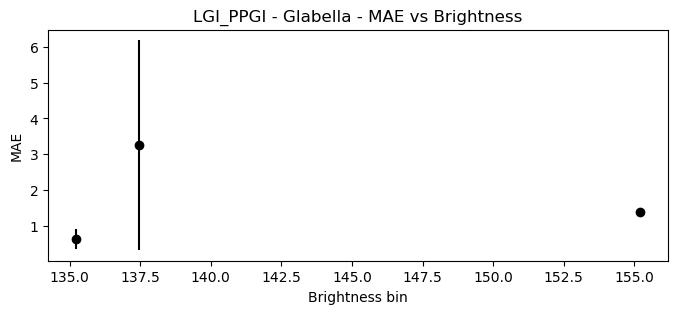

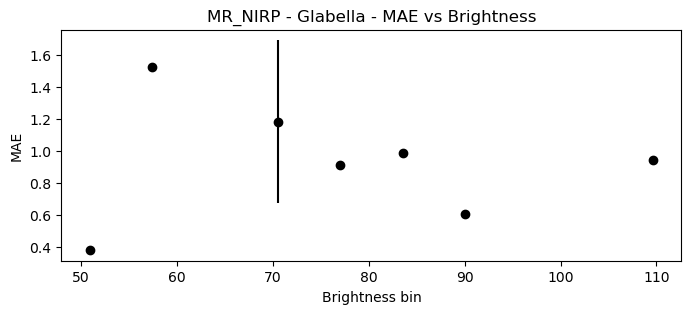

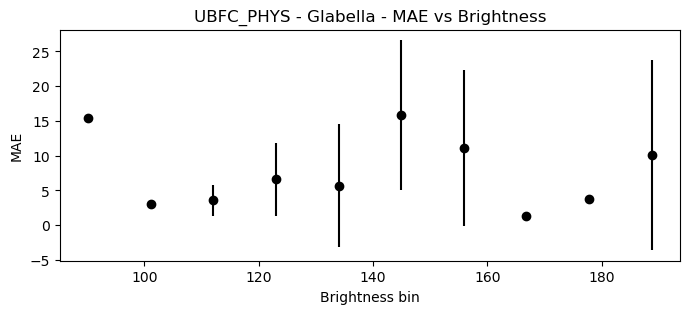

In [87]:
for dataset_name in DATASETS:
    dataset_name = dataset_name.lower()
    tmp = df.query(f'dataset == "{dataset_name}"').query('landmarks == "glabella"')
    # groupby brightness bin and calculate mean and std of MAE for each bin
    tmp['brightness_bin'] = pd.cut(tmp['brightness'], bins=10)
    tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
    tmp['std'] = tmp['std'].fillna(0)
    tmp['bin'] = tmp['brightness_bin'].apply(lambda x: x.mid) 
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    ax.errorbar(x=tmp['bin'], y=tmp['mean'], yerr=tmp['std'], fmt='o', color='black', capsize=0)
    ax.set_xlabel('Brightness bin')
    ax.set_ylabel('MAE')
    ax.set_title(f'{dataset_name.upper()} - Glabella - MAE vs Brightness')

# plot histogram with brightness bins as x axis
# fig, ax = plt.subplots(1,1, figsize=(8,3))
# sns.histplot(data=tmp, x='brightness_bin', y='mean', bins=50, kde=True, ax=ax)
